In [1]:
model_paths = '../output/ablation-mnist-models/*/*.pkl'
relu_path = '../output/ablation-mnist-models/attempt0/relu.pkl'
all_modifications_path = '../output/ablation-mnist-models/attempt0/relog-elliptical-maxout_4-bce-max_fit_l1-overlay.pkl'

# Preparation

In [2]:
import sys
sys.path.append('..')

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

In [4]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [5]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=False,
            transform=torchvision.transforms.ToTensor(), 
        )

In [6]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
x, y = next(iter(loader))

In [7]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return (batch * stds + means).clamp(0, 1)

cifar_classes = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck',
}

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')
            
    def plot_predictions(self, model, name=None, ax=None):
        name = name or model.name
        model.eval()
        preds, _ = model(self.xs)
        preds = softmax_dim1(preds)
        # because many classes have the same zero prob, we need an additional criteria to
        # choose one that makes the most sense
        mass = preds.sum(axis=0)
        preds_on_true_image, preds_on_noise = preds[0], preds[-1].clone()
        c0, c1 = sorted(range(preds.shape[1]), key=lambda i: (-preds_on_true_image[i], -mass[i]))[:2]
        remaining_indices = [i for i in range(preds.shape[1]) if i not in (c0, c1)]
        c2, c3 = sorted(remaining_indices, key=lambda i: (-preds_on_noise[i], -mass[i]))[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            if self.is_cifar:
                class_name = cifar_classes[c]
            else:
                class_name = str(c)
            (ax or plt).plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %s' %class_name)
        if ax is None: 
            plt.ylim(0, 1)
            plt.title('Model: ' + name)
        else:
            ax.set_ylim(0, 1)
            ax.set_title('Model: ' + name)
        (ax or plt).legend()

In [8]:
def compare_visually(model_a, model_b, idx, is_cifar=False):
    p = Plotter(idx, is_cifar=is_cifar)
    plt.ion()
    p.plot_transition()
    _, axes = plt.subplots(1, 2, figsize=(15,4))
    p.plot_predictions(model_a, ax=axes[0])
    p.plot_predictions(model_b, ax=axes[1])
    plt.ioff()

# Compare two models visually

In [9]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)
model_a.name = 'Baseline'
model_b.name = 'Proposed'

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.ReLog' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.Elliptical' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Plotting image at index 84


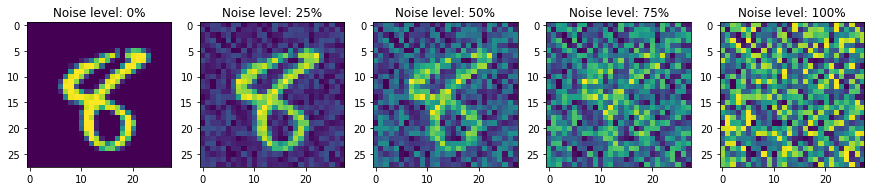

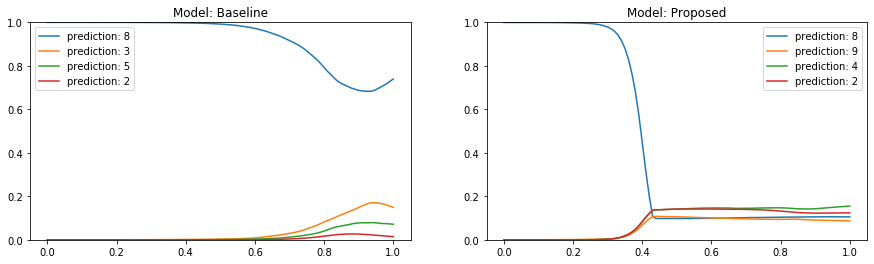

In [10]:
compare_visually(model_a, model_b, 84)

Plotting image at index 41


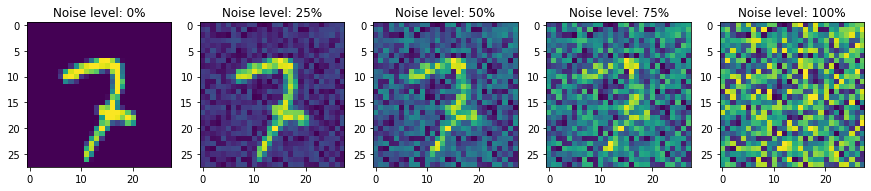

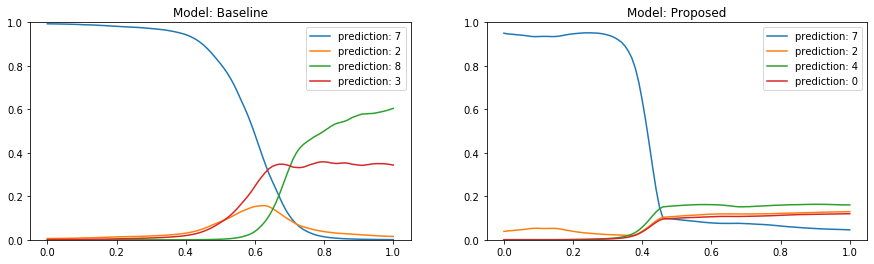

In [11]:
compare_visually(model_a, model_b, 41)

Plotting image at index 8


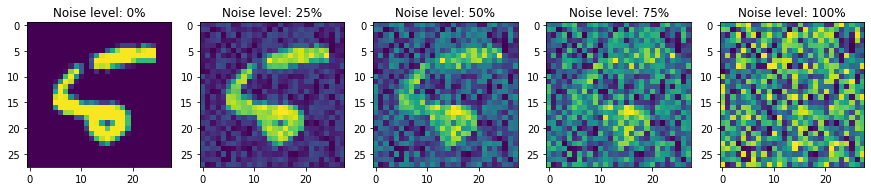

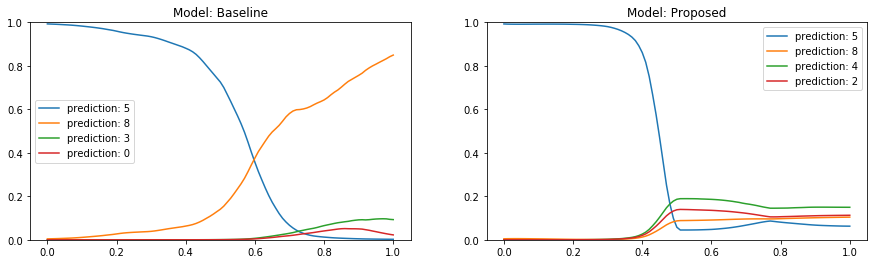

In [12]:
compare_visually(model_a, model_b, 8)

Plotting image at index 908


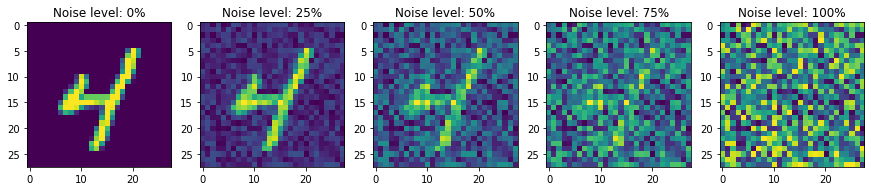

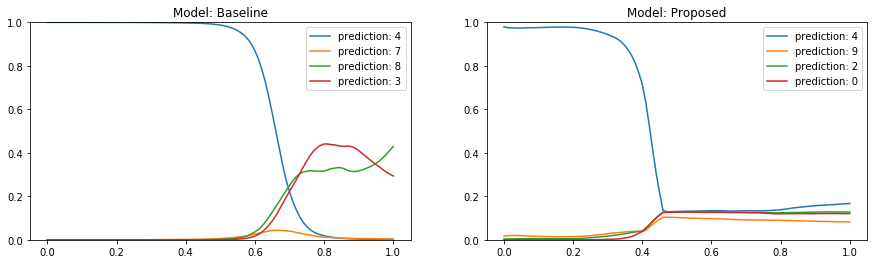

In [13]:
compare_visually(model_a, model_b, 908)

# Evaluate models

In [58]:
def evaluate(model, is_cifar=False):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)
    x, y = next(iter(loader))
    if is_cifar:
        noise_images = torch.randn(*x.shape)
    else:
        noise_images = torch.rand(*x.shape)
    
    preds_on_real, _ = model(x)
    max_probs_on_real, predicted_classes = softmax(preds_on_real, dim=1).max(dim=1)
    accuracy_on_real = (predicted_classes == y).float().mean()
    
    preds_on_noise, _ = model(noise_images)
    max_probs_on_noise, _ = softmax(preds_on_noise, dim=1).max(dim=1)
    accuracy_on_noise = (max_probs_on_noise < 0.5).float().mean()
    
    return {
        'acc_on_real': accuracy_on_real.item(),
        'prob_on_real': max_probs_on_real.mean().item(),
        'acc_on_noise': accuracy_on_noise.item(),
        'prob_on_noise': max_probs_on_noise.mean().item(),
    }

# evaluate(load_model('../output/ablation-mnist-models/attempt1/relu-bce-overlay.pkl'))

In [16]:
results = []
with tqdm(glob(model_paths)) as progress:
    for model_path in progress:
        model = load_model(model_path)
        row = evaluate(model)
        row['path'] = model_path
        results.append(row)

100%|██████████| 110/110 [06:00<00:00,  3.28s/it]


In [17]:
results = pd.DataFrame(results)

In [18]:
results['attempt'] = results.path.str.extract(r'/attempt(\d+)/')
results['model'] = results.path.str.extract(r'/([^/]+).pkl$')

In [19]:
results.sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
70,0.992,0.992763,0.246,0.599039,../output/ablation-mnist-models/attempt1/relu.pkl,1,relu
101,0.992,0.985550,0.032,0.882680,../output/ablation-mnist-models/attempt9/relog...,9,relog-elliptical-maxout_4-max_fit_l1
72,0.929,0.847077,0.000,0.980608,../output/ablation-mnist-models/attempt1/relog...,1,relog-elliptical-maxout_4


In [20]:
results[results.model.str.contains('elliptical')].sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
75,0.957,0.961789,0.024,0.827635,../output/ablation-mnist-models/attempt1/relog...,1,relog-elliptical-bce-max_fit_l1-overlay
57,0.995,0.985715,0.026,0.880302,../output/ablation-mnist-models/attempt6/relog...,6,relog-elliptical-maxout_4-max_fit_l1
5,0.975,0.967726,1.000,0.143689,../output/ablation-mnist-models/attempt2/relog...,2,relog-elliptical-maxout_4-bce-max_fit_l1-overlay


In [21]:
results.model.unique()

array(['relog', 'relog-maxout_4', 'relog-elliptical-maxout_4-max_fit_l1',
       'relog-elliptical-maxout_4-bce-max_fit_l1', 'relu',
       'relog-elliptical-maxout_4-bce-max_fit_l1-overlay',
       'relog-elliptical-maxout_4', 'relog-minmaxout_2_4', 'relu-bce',
       'relog-elliptical-bce-max_fit_l1-overlay', 'relu-bce-overlay'],
      dtype=object)

In [25]:
formatted_names = OrderedDict([
    ('relu', 'Baseline'),
    ('relog-elliptical-maxout_4-max_fit_l1', 'Innate'),  
    ('relu-bce-overlay', 'Learned'),
    ('relog-elliptical-maxout_4-bce-max_fit_l1-overlay', 'Both'),  
])
model_order = {n: i for i, n in enumerate(formatted_names)}

In [26]:
full_summary = results.drop(columns=['attempt', 'path']).groupby('model').agg(['mean', 'std']).reset_index()
full_summary

model acc_on_real            \
                                                            mean       std   
0                                              relog      0.9882  0.004211   
1            relog-elliptical-bce-max_fit_l1-overlay      0.9465  0.054561   
2                          relog-elliptical-maxout_4      0.9487  0.014369   
3           relog-elliptical-maxout_4-bce-max_fit_l1      0.9716  0.010648   
4   relog-elliptical-maxout_4-bce-max_fit_l1-overlay      0.9584  0.023959   
5               relog-elliptical-maxout_4-max_fit_l1      0.9918  0.002860   
6                                     relog-maxout_4      0.9920  0.002000   
7                                relog-minmaxout_2_4      0.9916  0.003627   
8                                               relu      0.9921  0.002331   
9                                           relu-bce      0.9925  0.001716   
10                                  relu-bce-overlay      0.9933  0.002263   

   prob_on_real           acc_on_noise           prob_on_noise            
           mean       std         mean       std          mean       std  
0      0.987267  0.002104       0.0362  0.025407      0.819449  0.052889  
1      0.923377  0.101810       0.1645  0.229680      0.756765  0.176049  
2      0.854127  0.020037       0.0029  0.004149      0.959793  0.034816  
3      0.966037  0.016951       0.0000  0.000000      0.996612  0.003236  
4      0.955582  0.024156       0.9230  0.243144      0.211659  0.156080  
5      0.984779  0.002625       0.0230  0.035036      0.908568  0.075599  
6      0.988910  0.001804       0.0279  0.040101      0.875480  0.085965  
7      0.986150  0.002563       0.0359  0.040076      0.838537  0.091862  
8      0.991221  0.001224       0.2283  0.146173      0.639225  0.075377  
9      0.994819  0.000960       0.1028  0.048878      0.734760  0.090223  
10     0.995874  0.000996       0.2716  0.128025      0.644278  0.090217

In [27]:
summary = full_summary[full_summary.model.isin(formatted_names)]
summary['model_order'] = summary.model.apply(model_order.__getitem__)
summary = summary.sort_values(['model_order']).drop(columns='model_order')
summary['model'] = summary.model.apply(formatted_names.__getitem__)
summary = summary.reset_index(drop=True)
summary

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


model acc_on_real           prob_on_real           acc_on_noise  \
                   mean       std         mean       std         mean   
0  Baseline      0.9921  0.002331     0.991221  0.001224       0.2283   
1    Innate      0.9918  0.002860     0.984779  0.002625       0.0230   
2   Learned      0.9933  0.002263     0.995874  0.000996       0.2716   
3      Both      0.9584  0.023959     0.955582  0.024156       0.9230   

            prob_on_noise            
        std          mean       std  
0  0.146173      0.639225  0.075377  
1  0.035036      0.908568  0.075599  
2  0.128025      0.644278  0.090217  
3  0.243144      0.211659  0.156080

In [28]:
formatted = summary.round(2)
formatted['acc_on_noise_str'] = formatted[('acc_on_noise', 'mean')].astype(str) + ' pm ' + formatted[('acc_on_noise', 'std')].astype(str)
formatted = formatted.drop(columns=[('prob_on_real', 'std'), 'acc_on_real', 
                                  ('prob_on_noise', 'std'), 'acc_on_noise'])
print(formatted.to_latex().replace('pm', '$\pm$'))

\begin{tabular}{llrrl}
\toprule
{} &     model & prob\_on\_real & prob\_on\_noise & acc\_on\_noise\_str \\
{} &         mean & \multicolumn{2}{l}{mean} \\
\midrule
0 &  Baseline &         0.99 &          0.64 &     0.23 $\pm$ 0.15 \\
1 &    Innate &         0.98 &          0.91 &     0.02 $\pm$ 0.04 \\
2 &   Learned &         1.00 &          0.64 &     0.27 $\pm$ 0.13 \\
3 &      Both &         0.96 &          0.21 &     0.92 $\pm$ 0.24 \\
\bottomrule
\end{tabular}



### Previous result (2019)

```
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))
    
relu.pkl: 0.28 (std=0.05)
relog.pkl: 0.06 (std=0.03)
relu-maxout.pkl: 0.05 (std=0.02)
relu-minmaxout.pkl: 0.02 (std=0.01)
relu-elliptical.pkl: 0.01 (std=0.01)
relu-max_fit_l1.pkl: 0.48 (std=0.05)
relu-mse.pkl: 0.08 (std=0.03)
relu-mse-overlay.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-maxout_4-max_fit_l1.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit-maxout.pkl: 0.79 (std=0.04)
relu-elliptical-maxout.pkl: 0.03 (std=0.02)
```

# CIFAR-10 models

In [11]:
cifar10_baseline_path = '../output/ablation-cifar10-models/relu.pkl'
cifar10_architecture_path = '../output/ablation-cifar10-models4/relog-maxout-elliptical-maxfit.pkl'
cifar10_all_modifications_path = '../output/ablation-cifar10-models4/relog-maxout-elliptical-maxfit-bce-overlay.pkl'

In [12]:
cifar10_model_a = load_model(cifar10_baseline_path)
cifar10_model_b = load_model(cifar10_all_modifications_path)
cifar10_model_c = load_model(cifar10_architecture_path)

In [46]:
cifar10_model_a.name = 'Baseline'
cifar10_model_b.name = 'Proposed'

In [54]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
dataset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)

In [55]:
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)
x, y = next(iter(cifar10_testloader))

Plotting image at index 3


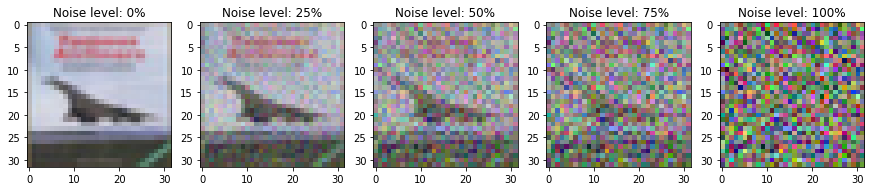

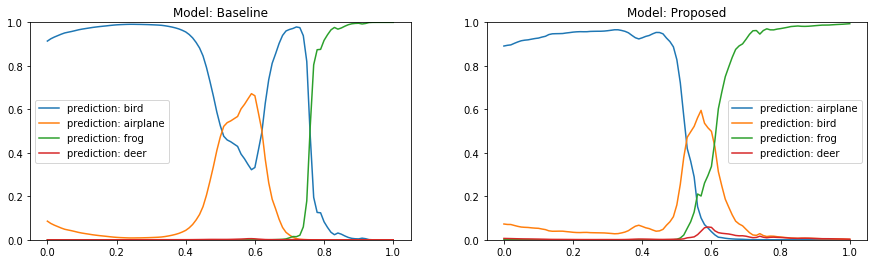

In [63]:
compare_visually(cifar10_model_a, cifar10_model_b, 3, is_cifar=True)

Plotting image at index 138


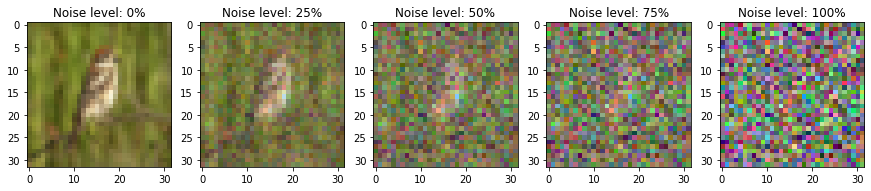

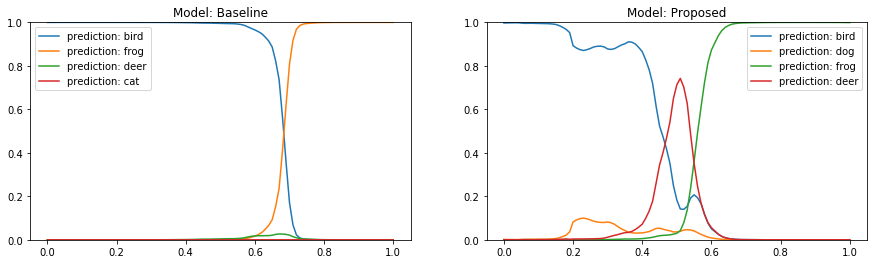

In [64]:
compare_visually(cifar10_model_a, cifar10_model_b, 138, is_cifar=True)

Plotting image at index 118


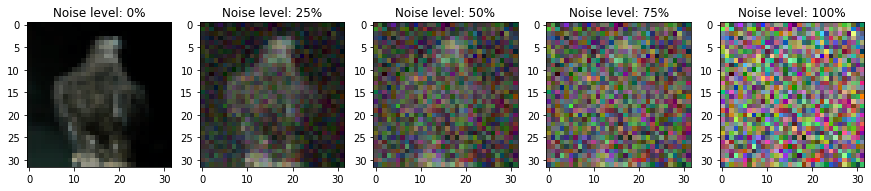

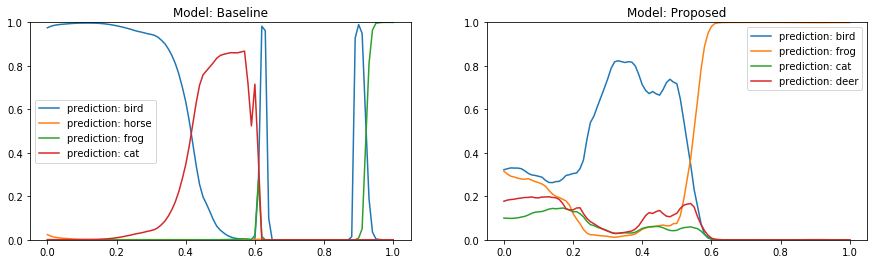

In [65]:
compare_visually(cifar10_model_a, cifar10_model_b, 118, is_cifar=True)

Plotting image at index 197


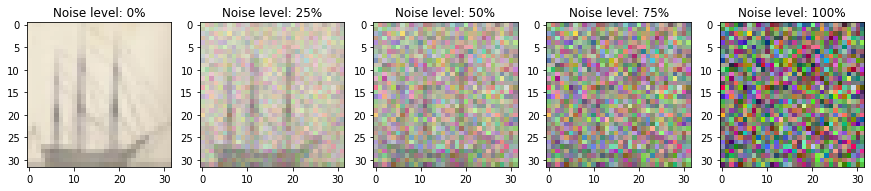

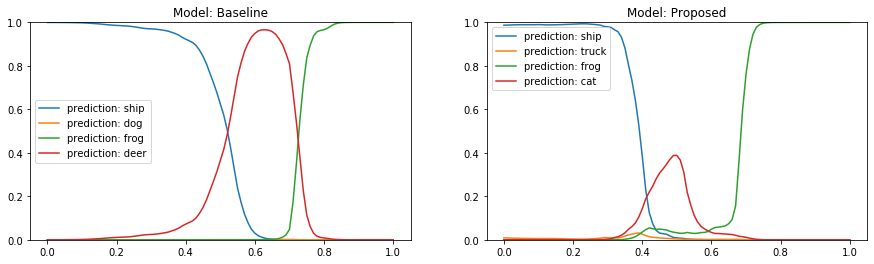

In [66]:
compare_visually(cifar10_model_a, cifar10_model_b, 197, is_cifar=True)

In [67]:
cifar10_model_c.name = 'Proposed architeture'

Plotting image at index 197


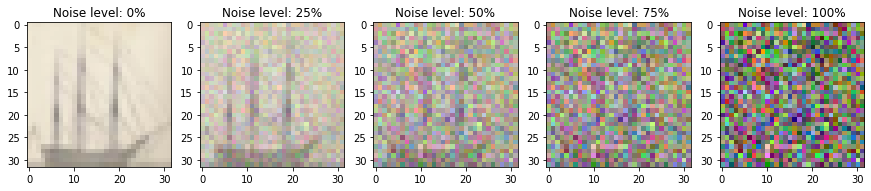

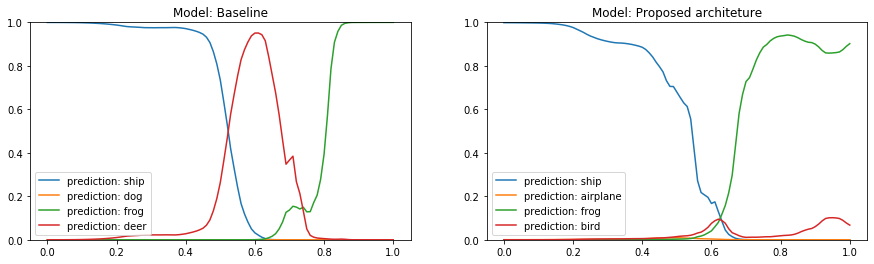

In [68]:
compare_visually(cifar10_model_a, cifar10_model_c, 197, is_cifar=True)

## Measure accuracy on noise

In [60]:
evaluate(cifar10_model_a, is_cifar=True)

{'acc_on_real': 0.7509999871253967,
 'prob_on_real': 0.9111194014549255,
 'acc_on_noise': 0.0,
 'prob_on_noise': 0.9984008073806763}

In [52]:
evaluate(cifar10_model_b, cifar10_testset)

{'acc_on_real': 0.6309999823570251,
 'prob_on_real': 0.7539497017860413,
 'acc_on_noise': 0.1679999977350235,
 'prob_on_noise': 0.6427867412567139}

In [53]:
evaluate(cifar10_model_c, cifar10_testset)

{'acc_on_real': 0.7689999938011169,
 'prob_on_real': 0.8421294689178467,
 'acc_on_noise': 0.05400000140070915,
 'prob_on_noise': 0.5903276205062866}